# Policy gradient for cartpole_v0 

In [44]:
import argparse
import json

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import gym
from gym import wrappers

from tqdm import tqdm_notebook

## Understand cartpole_v0

<img src='cartpole_v0_description.png' width=600>
Screenshot from <a href="https://github.com/openai/gym/wiki/CartPole-v0">OpenAI Gym Wiki: CartPole-v0</a>.

Check termination condition by sampling a random trajectory.

In [48]:
def print_observation(observation):
    cart_position, cart_velocity, pole_angle, pole_velocity = observation
    print(
        f"""
          Physical quantities    {"Value":<10} Caused termination
          =======================================================
          Cart Position          {cart_position:<10.3f} {np.abs(cart_position) > 2.4}
          Cart Velocity          {cart_velocity:<10.3f} N/A
          Pole Angle (Rad)       {pole_angle:<10.3f} {np.abs(np.rad2deg(pole_angle)) > 12}
          Pole Velocity At Tip   {pole_velocity:<10.3f} N/A"""
    )

In [49]:
import gym
env = gym.make('CartPole-v0')
env.reset()
observations = []
rewards = []
episode_len = 0

while True:
    observation, reward, done, _ = env.step(env.action_space.sample()) # take a random action
    observations.append(observation)
    rewards.append(reward)
    if done: 
        print(episode_len)
        print_observation(observation)
        break
    episode_len += 1
env.close()

observations = np.array(observations)
rewards = np.array(reward)

25

          Physical quantities    Value      Caused termination
          Cart Position          -0.170     False
          Cart Velocity          -0.751     N/A
          Pole Angle (Rad)       0.240      True
          Pole Velocity At Tip   1.416      N/A


Check the range of each observation dimension. Good news is that they appear to be quite normalized already, so we won't be normalizing them during training.

In [50]:
for i in range(4):
    print(f"Min: {observations[:,i].min():>10.5f} | Max: {observations[:,i].max():>10.5f}")
plt.show()

Min:   -0.16970 | Max:    0.01016
Min:   -0.94335 | Max:    0.42941
Min:   -0.04209 | Max:    0.24047
Min:   -0.59409 | Max:    1.63722


## Construct a policy-gradient solver

In [51]:
class NN(nn.Module):
    
    def __init__(self, num_neurons):
        super().__init__()
        self.main = nn.Sequential(
            
            nn.Linear(4, num_neurons),
            nn.ReLU(),
            
            nn.Linear(num_neurons, num_neurons),
            nn.ReLU(),
            
            nn.Linear(num_neurons, num_neurons),
            nn.ReLU(),
            
            nn.Linear(num_neurons, 2),
            nn.LogSoftmax(dim=-1)
        
        )
    
    def forward(self, xb):
        return self.main(xb)

In [87]:
class CartPolePGSolver():
    
    def __init__(
        self, 
        reward_to_go=True,
        normalize_advantages=True,
        baseline=False,
        discounting_factor=1., 
        episode_len=200, 
        pth_path=None
    ):
        self.reward_to_go = reward_to_go
        self.normalize_advantages = normalize_advantages
        self.baseline = baseline
        self.discounting_factor = discounting_factor
        self.episode_len = episode_len
        self.env = gym.make('CartPole-v1')
        self.create_model_and_optimizer()
        if pth_path is not None:
            self.model.load_state_dict(torch.load(pth_path))
            
    # ========== preprocessing functions for the neural net ==========
    
    # These functions do at least one of the following three things:
    # - Properly scale
    # - Convert numpy arrays into pytorch tensors
    # - Convert to the right data type
        
    def preprocess_observations(self, observations):
        """Helper function to self.preprocess."""
        #observations[:,0] /= 2.4   # divide by max value
        #observations[:,1] /= 5    # although unlikely, this dimension can take arbitrary large values; divide by 10 heuristically
        #observations[:,2] /= 0.21  # divide by max value (0.21 rad is about 12 degrees in degrees)
        #observations[:,3] /= 5    # although unlikely, this dimension can take arbitrary large values; divide by 10 heuristically
        return torch.from_numpy(observations).float()
        
    def preprocess_actions(self, actions):
        
        """
        Helper function to self.preprocess.
        
        Actions need to be converted into long intergers because they are used to
        index log-softmaxes.
        
        Note that log-softmaxes are different from logits. Logits are what the neural net
        outputs when the output layer has no activation function. Logits are converted 
        into probabilities using the softmax activation. Log-softmaxes are the results of
        applying the logarithm function to each of these probabilities, which is computed
        by the nn.LogSoftmax() layer in NN.main (see class NN).
        """
        
        return torch.from_numpy(actions).long()
    
    def preprocess_rewards(self, rewards):
        """Helper function to self.preprocess."""
        return torch.from_numpy(rewards)
    
    def preprocess(self, observations, actions, rewards):
        """Helper function to self.run."""
        return self.preprocess_observations(observations), self.preprocess_actions(actions), self.preprocess_rewards(rewards)
    
    # ========== create model and optimizer ==========
    
    def create_model_and_optimizer(self):
        self.model = NN(num_neurons=64) # TODO
        self.opt = optim.Adam(self.model.parameters(), lr=5e-3)  # TODO
    
    # ========== sample trajectory ==========
    
    def sample_trajectory(self, record=False, video_fname=None):
        """
        Sample a trajectory on-policy.
        """
        
        observations = []
        actions = []
        rewards = []
        
        if record:
            self.env = wrappers.Monitor(self.env, video_fname, force = True)
        observation = self.env.reset()
        observations.append(observation)
        
        for i in range(self.episode_len):
            
            with torch.no_grad():  # inference requires no gradient computation
                # catch: forgot to preprocess observations during sampling trajectory
                # shout out to this implemention: https://github.com/withai/Policy-Gradients-Full-RL-CartPole
                # but the strange thing was that it actually worked ...
                action_logsoftmaxs = self.model(torch.from_numpy(observation).view(1, 4).float()).detach().numpy().reshape(2, )
            action = np.random.choice([0, 1], p=np.exp(action_logsoftmaxs))
            actions.append(action)
            
            observation, reward, done, info = self.env.step(action)
            
            if self.reward_to_go:
                rewards.append(reward)
                for j in range(i):  
                    # j = 0, 1, 2, 3, ..., i-1
                    # (i-j) = i, i-1, i-2, i-3, ..., 1
                    #rewards[j] += (self.discounting_factor ** (i - j)) * reward
                    rewards[j] += reward
            else:
                rewards.append(reward)
                if done: rewards = [np.sum(rewards)] * len(rewards)
            
            if done: break  # if a certain dimension of observations is too large than some threshold
            
            # the last observation is not worth including since no action will be taken using it
            if i < self.episode_len - 1:
                observations.append(observation)  
                
        # these three arrays should all have the same number of rows
        return np.array(observations), np.array(actions), np.array(rewards)

    # ========== the policy gradient loop ==========
    
    def run(self, num_iterations, num_samples_per_iteration=100):
        
        self.model.train()
        
        reward_quantile_25_s = []
        reward_quantile_50_s = []
        reward_quantile_75_s = []
        
        for i in range(num_iterations):
            
            start = time.time()
            
            j_theta = torch.tensor([0.])
            total_rewards = []
            
            rewards_of_all_trajectories = []
            log_pi_a_s_of_all_trajectories = []
            
            for j in tqdm_notebook(list(range(num_samples_per_iteration))):
            
                observations, actions, rewards = self.preprocess(*self.sample_trajectory())
                
                total_rewards.append(float(rewards[0]))
                rewards_of_all_trajectories.append(rewards)
                
                log_pi_a_s = self.model(observations)[np.arange(len(observations)), actions]
                log_pi_a_s_of_all_trajectories.append(log_pi_a_s)
            
            rewards = torch.from_numpy(np.concatenate(rewards_of_all_trajectories))
            if self.normalize_advantages:
                rewards = (rewards - torch.mean(rewards)) / (torch.std(rewards) + 1e-4)
            log_pi_a_s = torch.cat(log_pi_a_s_of_all_trajectories)
            
            j_theta = torch.sum(log_pi_a_s * rewards) / num_samples_per_iteration
            weighted_nll = - j_theta

            self.opt.zero_grad()
            weighted_nll.backward()  # compute policy gradients
            self.opt.step()
            
            end = time.time()
            
            print(f"Iteration {i:>4} | Total reward {np.mean(total_rewards):>6.2f} | Duration {round(end - start, 2):>5.2f}")
            
            reward_quantile_25_s.append(np.quantile(total_rewards, 0.25))
            reward_quantile_50_s.append(np.quantile(total_rewards, 0.5))
            reward_quantile_75_s.append(np.quantile(total_rewards, 0.75))
            
        self.reward_quantile_25_s = np.array(reward_quantile_25_s)
        self.reward_quantile_50_s = np.array(reward_quantile_50_s)
        self.reward_quantile_75_s = np.array(reward_quantile_75_s)
        
    def save_model(self, fpath):
        torch.save(self.model.state_dict(), fpath)
        
    def save_reward_history(self, fpath):
        with open(fpath, "w+") as json_f:
            json.dump({
                25 : self.reward_quantile_25_s.tolist(), 
                50 : self.reward_quantile_50_s.tolist(),
                75 : self.reward_quantile_75_s.tolist()
            }, json_f)

## Experiments

In [88]:
# no need to run this cell unless you would like to re-train

parser = argparse.ArgumentParser()

parser.add_argument('--num_iterations', type=int, default=50)
parser.add_argument('--num_samples_per_iteration', type=int, default=100)
parser.add_argument('--rtg', type=bool, choices=[True, False], default=False)
parser.add_argument('--na', type=bool, choices=[True, False], default=False)

args = parser.parse_args("")

In [ ]:
# no need to run this cell unless you would like to re-train

for rtg in [False, True]:
    for na in [False, True]:
        
        args.rtg, args.na = rtg, na

        exp_name = f'cartpole_v0_pg_50_100{"_rtg" if args.rtg else ""}{"_na" if args.na else ""}'

        solver = CartPolePGSolver(
            reward_to_go=args.rtg,
            normalize_advantages=args.na
        )

        solver.run(
            num_iterations=args.num_iterations, 
            num_samples_per_iteration=args.num_samples_per_iteration
        )

        solver.save_model(f'{exp_name}.pth')
        solver.save_reward_history(f'{exp_name}.json')

In [94]:
def get_reward_quantiles_over_timestep(json_fname):
    with open(json_fname, 'r') as json_f:
        return json.load(json_f)

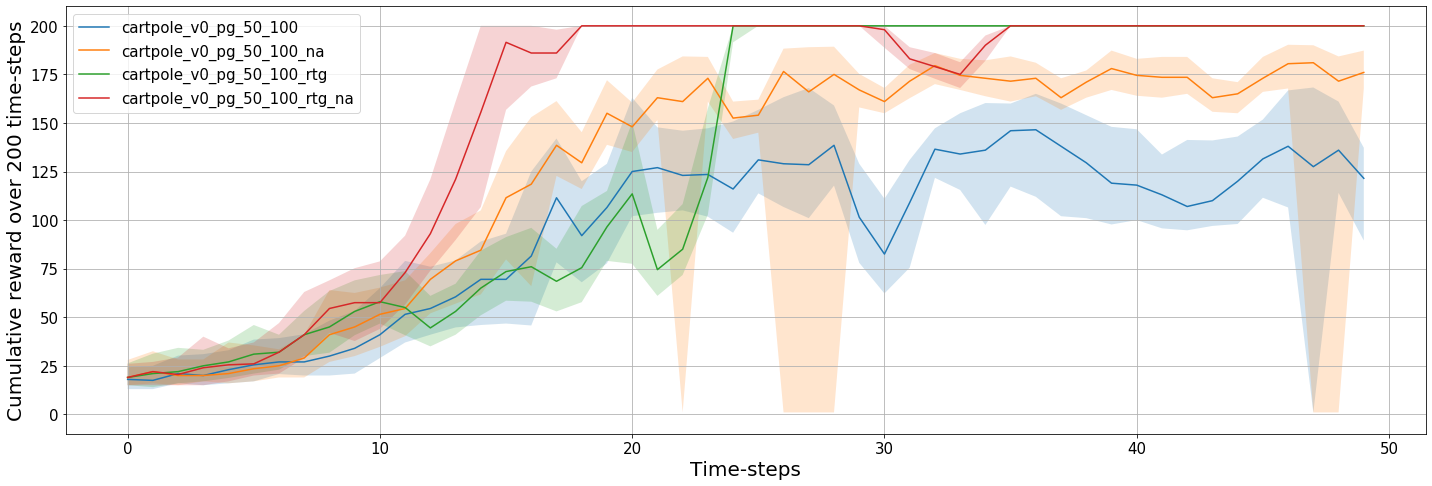

In [95]:
plt.figure(figsize=(20, 7))

for rtg in [False, True]:
    for na in [False, True]:
        
        exp_name = f'cartpole_v0_pg_50_100{"_rtg" if rtg else ""}{"_na" if na else ""}'
        reward_dict = get_reward_quantiles_over_timestep(exp_name + '.json')

        plt.plot(reward_dict['50'], label=exp_name)
        plt.fill_between(
            np.arange(len(reward_dict['50'])),
            reward_dict['25'],
            reward_dict['75'],
            alpha=0.2
        )

plt.ylim(0-10, 200+10)
plt.legend(fontsize=15)
plt.grid()

plt.xlabel('Time-steps', fontsize=20)
plt.ylabel('Cumulative reward over 200 time-steps', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()

## Sample a trajectory under a learned policy

In [106]:
trained_solver = CartPolePGSolver(
    reward_to_go=True,
    normalize_advantages=False,
    episode_len=200, 
    pth_path='cartpole_v0_pg_50_100_rtg_na.pth'
)
observations, actions, rewards = trained_solver.sample_trajectory()

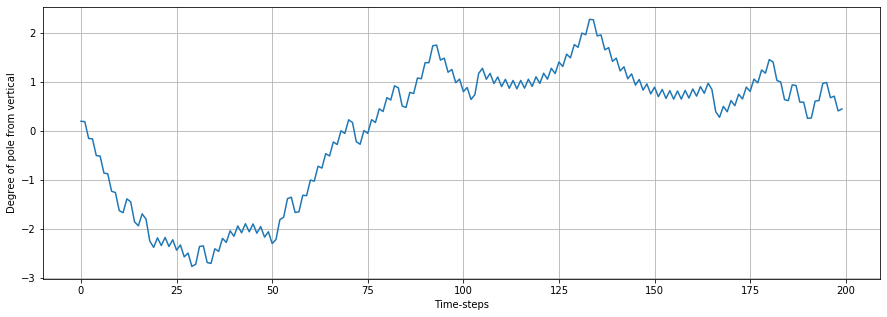

In [107]:
plt.figure(figsize=(15, 5))
plt.plot(np.rad2deg(observations[:,2]))
plt.xlabel('Time-steps'); plt.ylabel('Degree of pole from vertical')
plt.grid()
plt.show()

Shout out to <a href="https://github.com/openai/gym/issues/1254">OpenAI Gym Issue 1254</a> for writing the code snippets for outputting a video!